In [1]:
%matplotlib inline

# IMF API 3

Part 3 covers how to obtain metadata and how to make a more complicated API request.


### Obtaining the metadata
Part 2 explains how to generalize the example in part 1 by finding the codes which correspond to our data of interest and return successful API requests. However, the CompactData method used in part 1 does not return any metadata, such as full country names, the units of measure, or the indicator name.

Metadata are obtained by using the GenericMetadata method, demonstrated for the U.K. import price example from part 1 as follows:

In [2]:
import requests # Python 2.7, requests version 2.12.4

url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
key = 'GenericMetadata/IFS/M.GB.PMP_IX'
metadata = requests.get('{}{}'.format(url, key)).json()\
    ['GenericMetadata']['MetadataSet']['AttributeValueSet']
country = metadata[1]['ReportedAttribute'][1]\
    ['ReportedAttribute'][3]['Value']['#text']
indicator = metadata[2]['ReportedAttribute'][1]\
    ['ReportedAttribute'][4]['Value']['#text']
print 'Country: {}; Indicator: {}'.format(country, indicator)

Country: United Kingdom; Indicator: Index


The GenericMetadata method returns several options for country and indicator names, so it may be helpful to step into the JSON data and examine what is available directly, then use the appropriate keys to navigate the nested dictionaries and lists to the data of interest. 

### More complex requests

Perhaps we are interested in the share of goods the U.K. imports from the European Union, which requires information on both trade between the U.K and the EU, and on total U.K. trade. The API allows you to combine along a single dimension by adding '+'. For example, searching for the dimension 2 code in part 2 gives us B0 as the code for the EU, and W00 as the code for the world (total trade). 

Pandas is used for calculations and to make a simple line plot of the result.

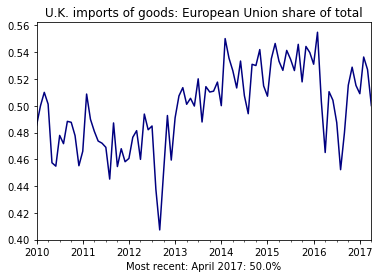

In [3]:
import pandas as pd           # pandas version 0.18.1

# key includes two partners, B0 and W00 for EU and world
key = 'CompactData/DOT/M.GB.TMG_CIF_USD.B0+W00'
dates = '?startPeriod=2010'     # limit start date

data = requests.get('{}{}{}'.format(url, key, dates)).json()\
                    ['CompactData']['DataSet']['Series']
# Create a dict of counterpart area code: its pandas dataframe
d = {partner['@COUNTERPART_AREA']: pd.DataFrame(partner['Obs'])
     .set_index('@TIME_PERIOD')['@OBS_VALUE'] for partner in data}
df = pd.concat(d, axis=1).astype(float).reset_index()  
df = df.set_index(pd.to_datetime(df['@TIME_PERIOD']))
eu_share = df['B0'].div(df['W00'])

# Create a line plot and print most recent value as x label
title = "U.K. imports of goods: European Union share of total"
recentdt = eu_share.dropna().index[-1].strftime('%B %Y')
recentval = (eu_share[-1] * 100).round(1)
recent = 'Most recent: {}: {}%'.format(recentdt, recentval)
ax = eu_share.plot(title=title, colormap='jet')
ax.set_xlabel(recent)

### Additional resources

On the IMF API side: 

The Data Services section of the IMF's website offers useful guidance on the APIs, and has a separate news section, which is a good place to check if something breaks. Finally, some guidance on handling large queries is available here:

On the Python side:


R package by Mingjer Lee to access the IMF API: 
https://github.com/mingjerli/IMFData